In [1]:
import os, random, numpy as np, tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D, Embedding, Concatenate, Input
from tensorflow.keras.preprocessing import sequence
from sklearn.metrics import classification_report, confusion_matrix
import time
import matplotlib.pyplot as plt
import seaborn as sns
os.environ["PYTHONHASHSEED"] = "9"
random.seed(9)
np.random.seed(9)
tf.keras.utils.set_random_seed(9)
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Concatenate, Dense, Dropout
from keras.preprocessing import sequence
from keras.models import Model
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve

In [2]:
csv_path = 'https://raw.githubusercontent.com/DyanielCX/DLI-Assm/refs/heads/main/dataset_B_05_2020_1.csv'
df = pd.read_csv(csv_path)

text_col_candidates = [c for c in df.columns if c.lower() in ['url','text','content','message','body','title'] or 'url' in c.lower()]
label_col_candidates = [c for c in df.columns if c.lower() in ['label','status','target','class','category','phishing']]

if not text_col_candidates or not label_col_candidates:
    raise ValueError(f"Could not infer columns. Columns found: {df.columns.tolist()}")

text_col = text_col_candidates[0]
label_col = label_col_candidates[0]

X_text = df[text_col].astype(str).fillna('')
y_raw = df[label_col].astype(str).fillna('')

X_train_text, X_temp_text, y_train_raw, y_temp_raw = train_test_split(X_text, y_raw, test_size=0.3, random_state=42, stratify=y_raw)
X_val_text, X_test_text, y_val_raw, y_test_raw = train_test_split(X_temp_text, y_temp_raw, test_size=0.5, random_state=42, stratify=y_temp_raw)

tokenizer = Tokenizer(lower=True, char_level=True, oov_token='-n-')
tokenizer.fit_on_texts(pd.concat([X_train_text, X_val_text, X_test_text], axis=0))

X_train = tokenizer.texts_to_sequences(list(X_train_text))
X_val = tokenizer.texts_to_sequences(list(X_val_text))
X_test = tokenizer.texts_to_sequences(list(X_test_text))

encoder = LabelEncoder()
encoder.fit(sorted(y_raw.unique()))
y_train = to_categorical(encoder.transform(y_train_raw))
y_val = to_categorical(encoder.transform(y_val_raw))
y_test = to_categorical(encoder.transform(y_test_raw))

# Parameters
epochs = 15
batch_size = 32
sequence_length = 200
embed_dim = 50

print(f'Using text column: {text_col}')
print(f'Using label column: {label_col}')
print('Data ready.')

Using text column: url
Using label column: status
Data ready.


In [3]:
def build_cnn_parallel(vocab_size, embed_dim=50, sequence_length=200, num_classes=2):
    inputs = Input(shape=(sequence_length,))
    x = Embedding(vocab_size + 1, embed_dim)(inputs)

    convs = []
    for k in [3, 5, 7]:
        c = Conv1D(filters=128, kernel_size=k, activation="relu", padding="same")(x)
        p = GlobalMaxPooling1D()(c)
        convs.append(p)

    x = Concatenate()(convs)
    x = Dense(128, activation="relu", name="cnn_features")(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation="sigmoid")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [4]:
x_train_pad = sequence.pad_sequences(X_train, maxlen=sequence_length)
x_val_pad = sequence.pad_sequences(X_val, maxlen=sequence_length)
x_test_pad = sequence.pad_sequences(X_test, maxlen=sequence_length)

vocab_size = len(tokenizer.word_index)
num_classes = y_train.shape[1]

cnn_model = build_cnn_parallel(vocab_size, embed_dim, sequence_length, num_classes)
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

start_time = time.time()
history = cnn_model.fit(
    x_train_pad, y_train,
    validation_data=(x_val_pad, y_val),
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    verbose=1
)
train_time = time.time() - start_time

test_loss, test_acc = cnn_model.evaluate(x_test_pad, y_test, verbose=0)

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(cnn_model.predict(x_test_pad, verbose=0), axis=1)
report = classification_report(y_true, y_pred, digits=4)
cm = confusion_matrix(y_true, y_pred)

print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")
print(report)


Epoch 1/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - accuracy: 0.7172 - loss: 0.5604 - val_accuracy: 0.8769 - val_loss: 0.3115
Epoch 2/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 30s 120ms/step - accuracy: 0.8712 - loss: 0.3160 - val_accuracy: 0.9026 - val_loss: 0.2389
Epoch 3/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 38s 110ms/step - accuracy: 0.9125 - loss: 0.2264 - val_accuracy: 0.9131 - val_loss: 0.1966
Epoch 4/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 113ms/step - accuracy: 0.9417 - loss: 0.1628 - val_accuracy: 0.9230 - val_loss: 0.1924
Epoch 5/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 40s 110ms/step - accuracy: 0.9624 - loss: 0.1156 - val_accuracy: 0.9183 - val_loss: 0.1983
Epoch 6/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 113ms/step - accuracy: 0.9710 - loss: 0.0942 - val_accuracy: 0.9271 - val_loss: 0.2056
Epoch 7/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 112ms/step - accuracy: 0.9735 - loss: 0.0765 - val_accuracy: 0.9230 - val_loss: 0.2138
Epoch 8/15
251/251 ━━━━━━━━━━━━━━━━━━━━ 27s 109ms/step - accuracy: 0.9884 - loss: 0

In [5]:
# FEATURE EXTRACTION + COMBINATION
# Extract CNN intermediate features, merge with any tabular columns, and standardize.

X_all_seq = tokenizer.texts_to_sequences(list(X_text))
X_all_pad = pad_sequences(X_all_seq, maxlen=sequence_length)

feature_extractor = Model(
    inputs=cnn_model.input,
    outputs=cnn_model.get_layer("cnn_features").output
)
cnn_feats_all = feature_extractor.predict(X_all_pad, verbose=0)

ml_features = df.drop(columns=[text_col, label_col]).copy()

if ml_features.shape[1] == 0:
    X_combined = cnn_feats_all
else:
    scaler = StandardScaler()
    ml_scaled = scaler.fit_transform(ml_features.values)
    X_combined = np.hstack([cnn_feats_all, ml_scaled])

y_all = encoder.transform(y_raw)

print("cnn_feats_all:", cnn_feats_all.shape,
      "| tabular:", (ml_features.shape[0], ml_features.shape[1]),
      "| X_combined:", X_combined.shape)


cnn_feats_all: (11430, 128) | tabular: (11430, 87) | X_combined: (11430, 215)


[SVC] Best val acc at thr=0.495
Calibrated SVC test accuracy (tuned thr): 0.9891
Classification report:
               precision    recall  f1-score   support

           0     0.9929    0.9851    0.9890      1143
           1     0.9852    0.9930    0.9891      1143

    accuracy                         0.9891      2286
   macro avg     0.9891    0.9891    0.9891      2286
weighted avg     0.9891    0.9891    0.9891      2286



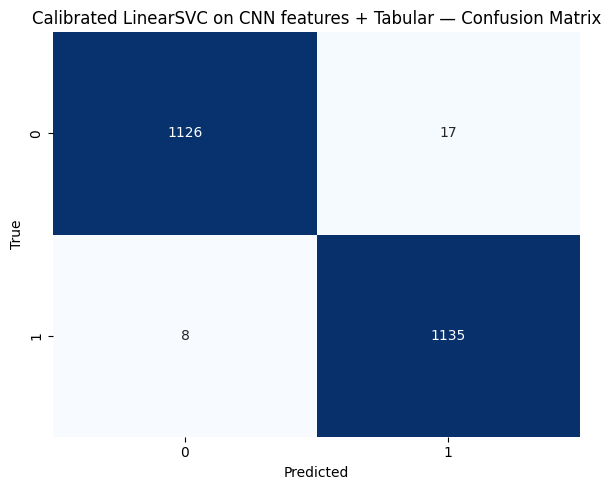

In [6]:
# MODEL TRAINING — CALIBRATED SVC WITH THRESHOLD TUNING
# Train LinearSVC wrapped in CalibratedClassifierCV, tune threshold on validation set for best accuracy.

# Fixed split seed for reproducibility
_split_seed = 9
X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(
    X_combined, y_all, test_size=0.2, stratify=y_all, random_state=_split_seed
)

# Further split training set into train/val
X_tr_c, X_val_c, y_tr_c, y_val_c = train_test_split(
    X_train_svc, y_train_svc, test_size=0.2, stratify=y_train_svc, random_state=42
)

# Base Linear SVC
base_svc = LinearSVC(
    loss="squared_hinge",
    penalty="l2",
    dual=True,
    max_iter=100000,
    tol=1e-3,
    class_weight="balanced",
    C=1.0,
    random_state=42
)

# Wrap with calibration
svc_cal = CalibratedClassifierCV(base_svc, cv=5, method="sigmoid")
svc_cal.fit(X_tr_c, y_tr_c)

# Threshold tuning on validation set
val_proba_svc = svc_cal.predict_proba(X_val_c)[:, 1]
thr_grid = np.linspace(0.05, 0.95, 181)
best_thr_svc, best_acc_svc = 0.5, 0.0
for t in thr_grid:
    acc = accuracy_score(y_val_c, (val_proba_svc >= t).astype(int))
    if acc > best_acc_svc:
        best_acc_svc, best_thr_svc = acc, t

print(f"[SVC] Best val acc at thr={best_thr_svc:.3f}")

# Re-train on full train set and evaluate on test set
svc_cal.fit(X_train_svc, y_train_svc)
test_proba_svc = svc_cal.predict_proba(X_test_svc)[:, 1]
svc_test_acc = accuracy_score(y_test_svc, (test_proba_svc >= best_thr_svc).astype(int))
print(f"Calibrated SVC test accuracy (tuned thr): {svc_test_acc:.4f}")
print("Classification report:\n", classification_report(
    y_test_svc, (test_proba_svc >= best_thr_svc).astype(int), digits=4
))

# Confusion matrix
cm = confusion_matrix(y_test_svc, (test_proba_svc >= best_thr_svc).astype(int))
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Calibrated LinearSVC on CNN features + Tabular — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [7]:
# MODEL TRAINING — LOGISTIC REGRESSION WITH THRESHOLD TUNING
# Train logistic regression on CNN+tabular features, tune threshold on validation set for best accuracy.

lr = LogisticRegression(
    C=4.0, penalty="l2",
    class_weight="balanced",
    solver="liblinear",
    max_iter=3000
)
lr.fit(X_tr_c, y_tr_c)

val_proba_lr = lr.predict_proba(X_val_c)[:, 1]
best_thr_lr, best_acc_lr = 0.5, 0.0
for t in thr_grid:
    acc = accuracy_score(y_val_c, (val_proba_lr >= t).astype(int))
    if acc > best_acc_lr:
        best_acc_lr, best_thr_lr = acc, t

print(f"[LR] Best val acc at thr={best_thr_lr:.3f}")

lr.fit(X_train_svc, y_train_svc)
test_proba_lr = lr.predict_proba(X_test_svc)[:, 1]
lr_test_acc = accuracy_score(y_test_svc, (test_proba_lr >= best_thr_lr).astype(int))
print(f" Logistic Regression test accuracy (tuned thr): {lr_test_acc:.4f}")


[LR] Best val acc at thr=0.650
 Logistic Regression test accuracy (tuned thr): 0.9886


In [8]:
# METRICS: Compute F1, ROC-AUC, PR-AUC for SVC and LR

results = {}

# --- SVC ---
y_pred_bin_svc = (test_proba_svc >= best_thr_svc).astype(int)
f1_svc = f1_score(y_test_svc, y_pred_bin_svc)
roc_auc_svc = roc_auc_score(y_test_svc, test_proba_svc)
pr_auc_svc = average_precision_score(y_test_svc, test_proba_svc)
results["SVC"] = {"acc": svc_test_acc, "f1": f1_svc, "roc_auc": roc_auc_svc, "pr_auc": pr_auc_svc}

# --- Logistic Regression ---
y_pred_bin_lr = (test_proba_lr >= best_thr_lr).astype(int)
f1_lr = f1_score(y_test_svc, y_pred_bin_lr)
roc_auc_lr = roc_auc_score(y_test_svc, test_proba_lr)
pr_auc_lr = average_precision_score(y_test_svc, test_proba_lr)
results["LR"] = {"acc": lr_test_acc, "f1": f1_lr, "roc_auc": roc_auc_lr, "pr_auc": pr_auc_lr}

print("Evaluation Results:")
for model, vals in results.items():
    print(f"{model}: Acc={vals['acc']:.4f}, F1={vals['f1']:.4f}, ROC-AUC={vals['roc_auc']:.4f}, PR-AUC={vals['pr_auc']:.4f}")


Evaluation Results:
SVC: Acc=0.9891, F1=0.9891, ROC-AUC=0.9988, PR-AUC=0.9987
LR: Acc=0.9886, F1=0.9886, ROC-AUC=0.9987, PR-AUC=0.9985


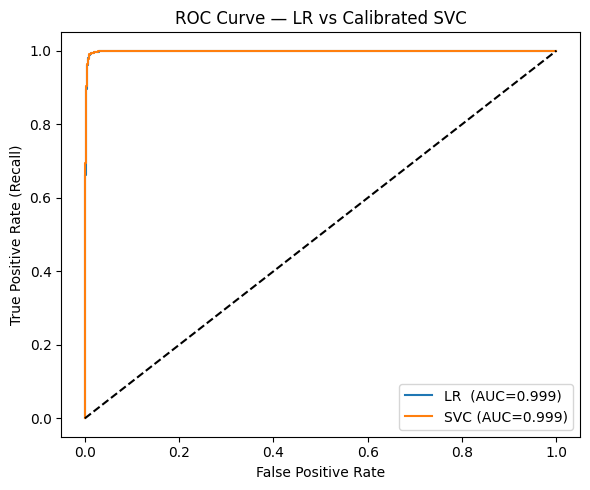

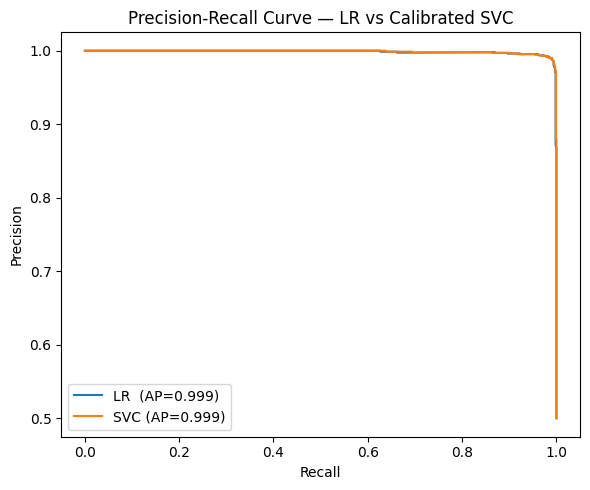

In [10]:
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score

# --- ROC Curves for LR and SVC ---
fpr_lr, tpr_lr, _ = roc_curve(y_test_svc, test_proba_lr)
roc_auc_lr = roc_auc_score(y_test_svc, test_proba_lr)

fpr_svc, tpr_svc, _ = roc_curve(y_test_svc, test_proba_svc)
roc_auc_svc = roc_auc_score(y_test_svc, test_proba_svc)

plt.figure(figsize=(6,5))
plt.plot(fpr_lr, tpr_lr, label=f"LR  (AUC={roc_auc_lr:.3f})")
plt.plot(fpr_svc, tpr_svc, label=f"SVC (AUC={roc_auc_svc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve — LR vs Calibrated SVC")
plt.legend()
plt.tight_layout()
plt.show()


# --- Precision-Recall Curves for LR and SVC ---
prec_lr, rec_lr, _ = precision_recall_curve(y_test_svc, test_proba_lr)
pr_auc_lr = average_precision_score(y_test_svc, test_proba_lr)

prec_svc, rec_svc, _ = precision_recall_curve(y_test_svc, test_proba_svc)
pr_auc_svc = average_precision_score(y_test_svc, test_proba_svc)

plt.figure(figsize=(6,5))
plt.plot(rec_lr, prec_lr, label=f"LR  (AP={pr_auc_lr:.3f})")
plt.plot(rec_svc, prec_svc, label=f"SVC (AP={pr_auc_svc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve — LR vs Calibrated SVC")
plt.legend()
plt.tight_layout()
plt.show()
